##### Copyright 2018 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Activation Grids -- Building Blocks of Interpretability

This colab notebook is part of our **Building Blocks of Intepretability** series exploring how intepretability techniques combine together to explain neural networks. If you haven't already, make sure to look at the [**corresponding paper**](https://distill.pub/2018/building-blocks) as well!

The notebook studies **activation grids** a technique for visualizing how a network "understood" an image at a particular layer.

<br>
<img src="https://storage.googleapis.com/lucid-static/building-blocks/notebook_heroes/activation-grid.jpeg" width="750"></img>
<br>

This tutorial is based on [**Lucid**](https://github.com/tensorflow/lucid), a network for visualizing neural networks. Lucid is a kind of spiritual successor to DeepDream, but provides flexible abstractions so that it can be used for a wide range of interpretability research.

**Note**: The easiest way to use this tutorial is [as a colab notebook](), which allows you to dive in with no setup. We recommend you enable a free GPU by going:

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

Thanks for trying Lucid!

#### **This notebook is a Jupyter version of the original Google Colab Notebook. This version adds widgets to facilitate the use of Lucid on your own images.**

# Install / Import

In [2]:
# !pip install --quiet --upgrade-strategy=only-if-needed git+https://github.com/tensorflow/lucid.git

import os

import numpy as np
import tensorflow as tf
assert tf.__version__.startswith('1')

import numpy as np
from ipyfilechooser import FileChooser
import ipywidgets as widgets
from IPython.display import display

import lucid.modelzoo.vision_models as models
from lucid.misc.io import show
import lucid.optvis.objectives as objectives
import lucid.optvis.param as param
import lucid.optvis.render as render
import lucid.optvis.transform as transform
from lucid.misc.channel_reducer import ChannelReducer

from lucid.misc.io import show, load, save

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.decomposition.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
model = models.InceptionV1()
model.layers

(Layer (belonging to InceptionV1) <conv2d0: 64> ([{'conv'}]),
 Layer (belonging to InceptionV1) <conv2d1: 64> ([{'conv'}]),
 Layer (belonging to InceptionV1) <conv2d2: 192> ([{'conv'}]),
 Layer (belonging to InceptionV1) <mixed3a: 256> ([{'conv'}]),
 Layer (belonging to InceptionV1) <mixed3b: 480> ([{'conv'}]),
 Layer (belonging to InceptionV1) <mixed4a: 508> ([{'conv'}]),
 Layer (belonging to InceptionV1) <mixed4b: 512> ([{'conv'}]),
 Layer (belonging to InceptionV1) <mixed4c: 512> ([{'conv'}]),
 Layer (belonging to InceptionV1) <mixed4d: 528> ([{'conv'}]),
 Layer (belonging to InceptionV1) <mixed4e: 832> ([{'conv'}]),
 Layer (belonging to InceptionV1) <mixed5a: 832> ([{'conv'}]),
 Layer (belonging to InceptionV1) <mixed5b: 1024> ([{'conv'}]),
 Layer (belonging to InceptionV1) <head0_bottleneck: 128> ([{'conv'}]),
 Layer (belonging to InceptionV1) <nn0: 1024> ([{'dense'}]),
 Layer (belonging to InceptionV1) <softmax0: 1008> ([{'dense'}]),
 Layer (belonging to InceptionV1) <head1_bottl

In [4]:
def render_activation_grid(
    img, model, layer="mixed4d", W=42, n_groups=6, subsample_factor=1, n_steps=256, verbose=True
):

    # Get the activations
    with tf.Graph().as_default(), tf.Session() as sess:
        t_input = tf.placeholder("float32", [None, None, None, 3])
        T = render.import_model(model, t_input, t_input)
        acts = T(layer).eval({t_input: img[None]})[0]
    acts_flat = acts.reshape([-1] + [acts.shape[2]])
    N = acts_flat.shape[0]

    # The trick to avoiding "decoherence" is to recognize images that are
    # for similar activation vectors and
    if n_groups > 0:
        reducer = ChannelReducer(n_groups, "NMF")
        groups = reducer.fit_transform(acts_flat)
        groups /= groups.max(0)
    else:
        groups = np.zeros([])

    print(groups.shape)

    # The key trick to increasing memory efficiency is random sampling.
    # Even though we're visualizing lots of images, we only run a small
    # subset through the network at once. In order to do this, we'll need
    # to hold tensors in a tensorflow graph around the visualization process.

    with tf.Graph().as_default() as graph, tf.Session() as sess:

        # Using the groups, create a paramaterization of images that
        # partly shares paramters between the images for similar activation
        # vectors. Each one still has a full set of unique parameters, and could
        # optimize to any image. We're just making it easier to find solutions
        # where things are the same.
        group_imgs_raw = param.fft_image([n_groups, W, W, 3])
        unique_imgs_raw = param.fft_image([N, W, W, 3])
        opt_imgs = param.to_valid_rgb(
            tf.stack(
                [
                    0.7 * unique_imgs_raw[i]
                    + 0.5
                    * sum(groups[i, j] * group_imgs_raw[j] for j in range(n_groups))
                    for i in range(N)
                ]
            ),
            decorrelate=True,
        )

        # Construct a random batch to optimize this step
        batch_size = 64
        rand_inds = tf.random_uniform([batch_size], 0, N, dtype=tf.int32)
        pres_imgs = tf.gather(opt_imgs, rand_inds)
        pres_acts = tf.gather(acts_flat, rand_inds)
        obj = objectives.Objective.sum(
            [
                objectives.direction(layer, pres_acts[n], batch=n)
                for n in range(batch_size)
            ]
        )

        # Actually do the optimization...
        T = render.make_vis_T(model, obj, param_f=pres_imgs)
        tf.global_variables_initializer().run()

        for i in range(n_steps):
            T("vis_op").run()
            if (i + 1) % (n_steps // 2) == 0 and verbose:
                show(pres_imgs.eval()[::4])

        vis_imgs = opt_imgs.eval()

    # Combine the images and display the resulting grid
    print("")
    vis_imgs_ = vis_imgs.reshape(list(acts.shape[:2]) + [W, W, 3])
    vis_imgs_cropped = vis_imgs_[:, :, 2:-2, 2:-2, :]
    if verbose:
        show(np.hstack(np.hstack(vis_imgs_cropped)))
    return vis_imgs_cropped

In [5]:
print(
    "Upload file from local machine and select uploading path (A) or just select one file (B):"
)
print("A1) Select a file to upload")
uploader = widgets.FileUpload(accept='', multiple=False)
display(uploader)

print("\nA2) Select destination for uploaded file")
print("B) Select file in this server")
notebooks_root_path = ""
fc = FileChooser(".",
                 use_dir_icons=True,
                 select_default=True)
display(fc)


print("\nSelect the destination folder of the activation grids: ")
dest_widget = widgets.Text(value='.',
                           placeholder='destination/',
                           description='Destination path:',
                           layout=widgets.Layout(width='70%'))

display(dest_widget)


layers_list = [layer.name for layer in model.layers[3:]]
print("\nCheck the layers you want to apply activation grid on : ")
layers_widget = widgets.SelectMultiple(
    options=layers_list,
    value=[layers_list[0]],
    description='Layers'
)
display(layers_widget)


display_results_widget = widgets.Checkbox(
    value=True,
    description='Display results in notebook',
    disabled=False,
    indent=False
)
display(display_results_widget)


save_results_widget = widgets.Checkbox(
    value=True,
    description='Save results as images in destination folder',
    disabled=False,
    indent=False
)
display(save_results_widget)

Upload file from local machine and select uploading path (A) or just select one file (B):
A1) Select a file to upload


FileUpload(value={}, description='Upload')


A2) Select destination for uploaded file
B) Select file in this server


FileChooser(path='.', filename='', show_hidden='False')


Select the destination folder of the activation grids: 


Text(value='.', description='Destination path:', layout=Layout(width='70%'), placeholder='destination/')


Check the layers you want to apply activation grid on : 


SelectMultiple(description='Layers', index=(0,), options=('mixed3a', 'mixed3b', 'mixed4a', 'mixed4b', 'mixed4c…

Checkbox(value=True, description='Display results in notebook', indent=False)

Checkbox(value=True, description='Save results as images in destination folder', indent=False)


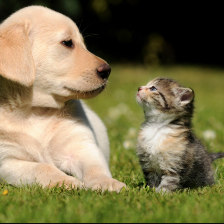

In [7]:
save_images = save_results_widget.value
verbose = display_results_widget.value

if uploader.value: # upload local file to server
    picture_name = uploader.value[0]
    content = uploader.value[picture_name]['content'] # memoryview of the file
    picture_full_path = os.path.join(fc.selected_path, picture_name)
    with open(picture_name, 'wb') as f:
        f.write(content)
else: # use files already on the server
    picture_full_path = fc.selected
        
selected_layers = layers_widget.value # layers to apply activation grid on

dest_path = dest_widget.value
    
img = load(picture_full_path)
show(img)

Setting optimization parameters: (you should adapt these parameters to your own model)

In [8]:
n_steps = 64#2048
n_groups = 12
grid_resolution = 672 # the total resolution of the activation grid
W = 12

In [ ]:
for layer_name in selected_layers:
    layer = model.get_layer(layer_name)
    print(layer.name)
    
    # if you defined a custom Lucid Model class as in lucid/misc/custom_model.py
    # you can define W depending on the spatial shape of the layer :
    # W = grid_resolution // layer.shape[0] 
    # Setting W to obtain a grid of size grid_resolution

    result = render_activation_grid(img, model, layer=layer.name, W=W, n_groups=n_groups, n_steps=n_steps,verbose=verbose)
    result = np.hstack(np.hstack(result))

    if save_images:
        image_name = "./spritemaps/activation_grid_%s.jpeg" % layer_name.split("/")[0]
        save(result, image_name)

mixed3a



(784, 12)



/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

